In [2]:
# ライブラリをインポート

# データ操作と数値計算のため
import pandas as pd
import numpy as np

# データ可視化のため
import matplotlib.pyplot as plt
import seaborn as sns

# 統計モデリングと計量経済分析のため
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# for ignore warning
import warnings
warnings.filterwarnings('ignore')

In [52]:
url = "https://www.fbc.keio.ac.jp/~tyabu/keiryo/dailyint_data.csv"
df = pd.read_csv(url)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.dropna()
df.head()

,date,spot,intervention
0,1991-04-01,139.30,0.0
1,1991-04-02,137.90,0.0
2,1991-04-03,137.38,0.0
3,1991-04-04,135.95,0.0
4,1991-04-05,136.60,0.0


In [53]:
df.describe()

,date,spot,intervention
count,3055,3055.000000,3055.000000
mean,1997-02-10 05:24:45.957446912,116.043676,-76.739771
min,1991-04-01 00:00:00,80.620000,-14059.000000
25%,1994-03-05 12:00:00,106.440000,0.000000
50%,1997-02-10 00:00:00,116.900000,0.000000
75%,2000-01-18 12:00:00,124.695000,0.000000
max,2002-12-31 00:00:00,147.200000,26201.000000
std,NaN,12.711133,883.624841


# 変数の定義
ドル円レートは変化率に、介入額(単位億円)は介入額(単位兆円)に変換

In [54]:
df['ds'] = 100 * ((np.log(df['spot'])) - np.log(df['spot'].shift()))
df['intj'] = df['intervention'] / 10000
df = df.dropna()
df.head()

,date,spot,intervention,ds,intj
1,1991-04-02,137.90,0.0,-1.010110,0.0
2,1991-04-03,137.38,0.0,-0.377798,0.0
3,1991-04-04,135.95,0.0,-1.046364,0.0
4,1991-04-05,136.60,0.0,0.476978,0.0
5,1991-04-08,137.10,0.0,0.365364,0.0


# 7.4.2節の推定結果
supF検定と構造変化日の特定

In [55]:
endog = df['ds']
exog = df['intj']
exog = sm.add_constant(exog)

model_1 = sm.OLS(endog, exog)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     ds   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     47.68
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           6.06e-12
Time:                        17:13:47   Log-Likelihood:                -3318.5
No. Observations:                3054   AIC:                             6641.
Df Residuals:                    3052   BIC:                             6653.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0130      0.013     -1.000      0.3

In [64]:
# F統計量を格納するデータフレームを作成
columns = ['date', 'f_stat']
df_f_stat = pd.DataFrame(columns=columns)

In [65]:
# 帰無仮説が正しいという前提で推定
endog = df_supf['ds']         # 被説明変数
exog = df_supf['intj']      # 説明変数
exog = sm.add_constant(exog) # 定数項を追加
H_0 = sm.OLS(endog, exog).fit()
ssr_0 = np.sum(H_0.resid**2) # 残差２乗和を取得

In [66]:
# 構造変化点の候補を計算する．
T = len(df) # サンプルサイズ

T_min = round(0.15 * T) # 構造変化点の候補の始期．整数を用いる
T_min_date = df.sort_values('date').iloc[T_min - 1]['date'] # date列でソートし，T_min番目の値を取得
print(f'構造変化点の候補の始期:{T_min_date}')

T_max = round((1 - 0.15) * T) # 構造変化点の候補の終期．整数を用いる
T_max_date = df.sort_values('date').iloc[T_max - 1]['date'] # date列でソートし，T_max番目の値を取得
print(f'構造変化点の候補の終期:{T_max_date}')

T_B_list = list(range(T_min, T_max + 1)) # 構造変化点の候補のリストを作成．
print(T_B_list)

# 構造変化点の候補を一つずつ試す．
for T_B in T_B_list:
    T_B_date = df.sort_values('date').iloc[T_B - 1]['date'] # date列でソートし，T_B番目の値を取得
    df['d'] = (df['date'] > T_B_date).astype(int) # 構造変化点の候補T_Bの期以前は0，それ以降は1
    df['d_intj'] = df['d'] * df['ds'].shift() # dが1のときだけ前期のgrowthを入れる．
    df_supf = df.dropna()
    
    # 対立仮説が正しいという前提で推定
    endog = df_supf['ds']                       # 被説明変数
    exog = df_supf[['intj', 'd', 'd_intj']] # 説明変数
    exog = sm.add_constant(exog)
    H_1 = sm.OLS(endog, exog).fit()
    ssr_1 = np.sum(H_1.resid**2) # 残差２乗和を取得

    # F統計量を計算する
    K = 1 # 制約なしモデルの説明変数の数
    f_stat = (ssr_0 - ssr_1) / (K + 1) / ssr_1 * (T - 2 * (K + 1)) # F統計量を計算する．

    new_f_stat = pd.Series(
        [T_B_date, f_stat],
        index = df_f_stat.columns
    )
    df_f_stat = pd.concat(
        [
            df_f_stat,
            new_f_stat.to_frame().T
        ],
        ignore_index = True
    )

構造変化点の候補の始期:1992-12-31 00:00:00
構造変化点の候補の終期:2001-03-26 00:00:00
[458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 

In [60]:
# 帰無仮説が正しいという前提で推定
endog = df_supf['ds']         # 被説明変数
exog = df_supf['intj']      # 説明変数
exog = sm.add_constant(exog) # 定数項を追加
H_0 = sm.OLS(endog, exog).fit()
ssr_0 = np.sum(H_0.resid**2) # 残差２乗和を取得

構造変化点:1998-10-01 00:00:00
supF統計量:4.17


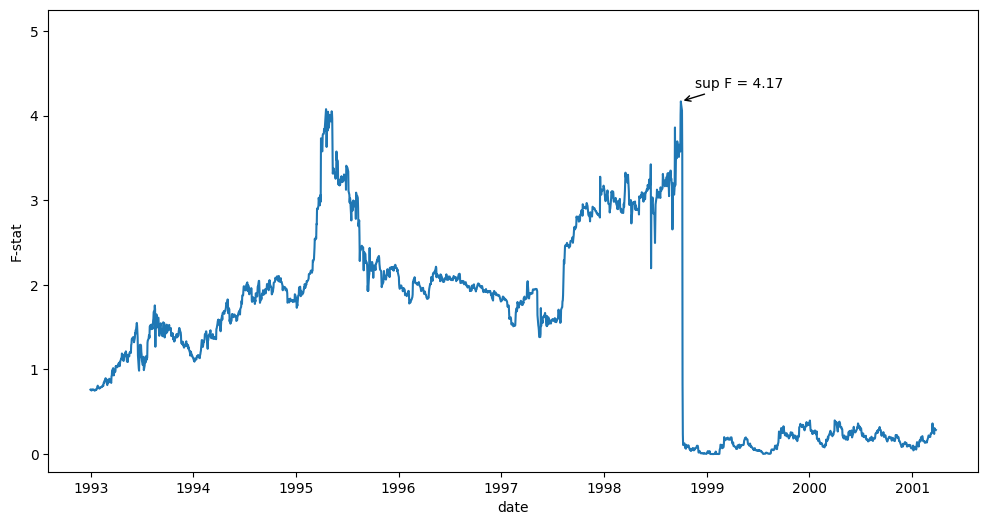

In [67]:
sup_f_stat = df_f_stat['f_stat'].max() # F値の最大値
structural_break_point = df_f_stat.loc[df_f_stat['f_stat'].idxmax(), 'date'] # 構造変化点を取得
print(f'構造変化点:{structural_break_point}')
print(f'supF統計量:{sup_f_stat:.02f}')

plt.figure(figsize=(12, 6))
plt.plot(
    df_f_stat['date'],
    df_f_stat['f_stat'],
)
plt.xlabel('date')
plt.ylabel('F-stat')

current_ymin, current_ymax = plt.ylim()
plt.ylim(current_ymin, current_ymax * 1.2)

# 最大値の位置にテキストで値を表示
plt.annotate(
    f'sup F = {sup_f_stat:.2f}',
    xy = (structural_break_point, sup_f_stat),
    xytext = (10, 10),
    textcoords = 'offset points',
    arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0')
)
plt.show()


In [61]:
def sup_f_test(df_supf=df_supf):

    # F統計量を格納するデータフレームを作成
    columns = ['date', 'f_stat']
    df_f_stat = pd.DataFrame(columns=columns)

    # 構造変化点の候補を計算する．
    T = len(df_supf) # サンプルサイズ

    T_min = round(0.15 * T) # 構造変化点の候補の始期．整数を用いる
    T_min_date = df_supf.sort_values('date').iloc[T_min - 1]['date'] # date列でソートし，T_min番目の値を取得
    print(f'構造変化点の候補の始期:{T_min_date}')

    T_max = round((1 - 0.15) * T) # 構造変化点の候補の終期．整数を用いる
    T_max_date = df_supf.sort_values('date').iloc[T_max - 1]['date'] # date列でソートし，T_max番目の値を取得
    print(f'構造変化点の候補の終期:{T_max_date}')

    T_B_list = list(range(T_min, T_max + 1)) # 構造変化点の候補のリストを作成．

    # 帰無仮説が正しいという前提で推定
    endog = df_supf['ds']         # 被説明変数
    exog = df_supf['intj']      # 説明変数
    exog = sm.add_constant(exog) # 定数項を追加
    H_0 = sm.OLS(endog, exog).fit()
    ssr_0 = np.sum(H_0.resid**2) # 残差２乗和を取得

    # 構造変化点の候補を一つずつ試す．
    for T_B in T_B_list:
        T_B_date = df_supf.sort_values('date').iloc[T_B - 1]['date'] # date列でソートし，T_B番目の値を取得
        df_supf['d'] = (df_supf['date'] > T_B_date).astype(int) # 構造変化点の候補T_Bの期以前は0，それ以降は1
        df_supf['d_intj'] = df_supf['d'] * df_supf['ds'].shift() # dが1のときだけ前期のgrowthを入れる．
        df_supf = df_supf.dropna()

        # 対立仮説が正しいという前提で推定
        endog = df_supf['ds']                       # 被説明変数
        exog = df_supf[['intj', 'd', 'd_intj']] # 説明変数
        exog = sm.add_constant(exog)
        H_1 = sm.OLS(endog, exog).fit()
        ssr_1 = np.sum(H_1.resid**2) # 残差２乗和を取得

        # F統計量を計算する
        K = 1 # 制約なしモデルの説明変数の数
        f_stat = (ssr_0 - ssr_1) / (K + 1) / ssr_1 * (T - 2 * (K + 1)) # F統計量を計算する．

        new_f_stat = pd.Series(
            [T_B_date, f_stat],
            index = df_f_stat.columns
        )
        df_f_stat = pd.concat(
            [
                df_f_stat,
                new_f_stat.to_frame().T
            ],
            ignore_index = True
        )

    sup_f_stat = df_f_stat['f_stat'].max() # F値の最大値
    structural_break_point = df_f_stat.loc[df_f_stat['f_stat'].idxmax(), 'date'] # 構造変化点を取得
    print(f'構造変化点:{structural_break_point}')
    print(f'supF統計量:{sup_f_stat:.02f}')

    plt.figure(figsize=(12, 6))
    plt.plot(
        df_f_stat['date'],
        df_f_stat['f_stat'],
    )
    plt.xlabel('date')
    plt.ylabel('F-stat')

    current_ymin, current_ymax = plt.ylim()
    plt.ylim(current_ymin, current_ymax * 1.2)

    # 最大値の位置にテキストで値を表示
    plt.annotate(
        f'sup F = {sup_f_stat:.2f}',
        xy = (structural_break_point, sup_f_stat),
        xytext = (10, 10),
        textcoords = 'offset points',
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    )
    plt.show()

    return

In [22]:
sup_f_test()

構造変化点の候補の始期:1993-02-24 00:00:00
構造変化点の候補の終期:2002-01-22 00:00:00


KeyError: 'ds'

In [ ]:
fs1 <- Fstats(ds~intj, data = Dat, from = 0.15, to = 0.85)
fs <- fs1$Fstats
Dat2 <- Dat[(459:2596),]　#両端15％をカット
Dat3 <- cbind(Dat2,fs)
Dat3[,1] <- as.Date(Dat3[,1],"%m/%d/%Y")
Dat3
plot(Dat3$date,Dat3$fs,type="l") #wald統計量の推移
max(Dat3$fs) 
  ##33.899と計算されるが制約数が２であるため、２で除すと16.945となり教科書と一致
Dat3[Dat3$fs >= 33.8,] #構造変化点




前半(1995/4/18まで)と後半(1995/4/19から)で分けて、別々に推定する

In [ ]:
Out2 <- lm(ds ~ intj , subset = (time <= 1056), data=Dat)
Out3 <- lm(ds ~ intj , subset = (time > 1056), data=Dat)

mtable(Out2,Out3)

##推定結果の頑健性を調べるため、説明変数に新たにdsの1期前の値を加える---------------------------------------------------------------------------
Out4 <- lm(ds ~ intj + lag(ds) , data=Dat)
summary(Out4)
 
fs2 <- Fstats(ds~intj+lag(ds), data = Dat1, from = 0.15 , to = 0.85)
fs2_1 <- fs2$Fstats
Dat4 <- Dat1[(459:2597),] #両端15％をカット
Dat5 <- cbind(Dat4, fs2_1)
Dat5[,1] <- as.Date(Dat5[,1],"%m/%d/%Y")
plot(Dat5$date, Dat5$fs2_1, type="l")
max(Dat5$fs2_1)
Dat5[Dat5$fs2_1 >= 39.4,] #構造変化点

##構造変化日は1072(1995/5/10)となっているので、TBは1071(1995/5/9)下では、構造変化前後で別々に推定する
Out5 <- lm(ds ~ intj + lag(ds),subset = (time <= 1071),data=Dat1)
Out6 <- lm(ds ~ intj + lag(ds),subset = (time > 1071),data=Dat1)

mtable(Out5,Out6)


